#Pokemon Data Analysis - Generation 1
This is a web scrape and analysis of the generation 1 pokedex. All pokemon will have their original typings (no steel, fairy or dark), and their stats will be faithful to the original pokedex.   

I will analyse the distributions of each typing for both mono and dual-type pokemon, and calculate each pokemon's maximum level 100 fully-trained stats.   

Finally, I will write a damage calculator using the original formula to see how much damage each pokemon in the pokedex takes from:   
-Gyarados's hyper beam   
-Mewtwo's psychic   
-Pikachu's thunder   
-Golem's explosion   
-Charizard's fire blast   
-Blastoise's hydro pump   
-Venusaur's solar beam   

This data will be scraped, generated, calculated and stored as CSV files on GitHub.   

**Stages of the Analysis**   
1- Importing required Python libraries   
2- Primary pokedex DataFrame creation   
3- Performing an analysis of the pokedex type distribution   
4- Performing an analysis of the pokedex stat distributions   
5- Create a DataFrame of the attacking moves to use in the exploration   
6- Create functions for damage, level 100 stats and battle mechanics   
7- Create a DataFrame and pivot table of each types coverage in the pokedex   
8- Explore the damage distribution of 7 popular pokemon and their moves   
9- Conclusion and link to Tableua public   
10- Extra code sandbox area for viewer testing


## 1- All Library Imports
Pandas and numpy for general data analysis   
Mat plot lib and seaborn for visualisation   
Requests to save webpage data, and beautiful soup to scrape the information needed   

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests

#2- Primary pokedex Data Frame creation
This is the primary scrape of the pokedex, cleaning it up and adding the stats.

## Initial Web Scraping
Get data from Bulbapedia, assemble and scrape required data into a data frame.

In [ ]:
# Save webpage data and create beautiful soup variable (pokemon dex, names and types)
url = "https://bulbapedia.bulbagarden.net/wiki/List_of_Pok%C3%A9mon_by_Kanto_Pok%C3%A9dex_number"
raw_page = requests.get(url)
soup = BeautifulSoup(raw_page.text, "html.parser")

In [ ]:
# Find all 3x tables with the pokemon data on the page
table_1 = soup.find_all("table")[1]
table_2 = soup.find_all("table")[2]
table_3 = soup.find_all("table")[3]

In [ ]:
# Find all pokemon by the TR tag
mons_1 = table_1.find_all("tr")
mons_2 = table_2.find_all("tr")
mons_3 = table_3.find_all("tr")
tables = [mons_1, mons_2, mons_3]

<tr style="background:#FFF">
<td style="font-family:monospace">#001
</td>
<td style="font-family:monospace">#0001
</td>
<th><a href="/wiki/Bulbasaur_(Pok%C3%A9mon)" title="Bulbasaur"><img alt="Bulbasaur" decoding="async" height="52" loading="lazy" src="//archives.bulbagarden.net/media/upload/7/71/001MSPE.png" width="52"/></a>
</th>
<td><a href="/wiki/Bulbasaur_(Pok%C3%A9mon)" title="Bulbasaur (Pokémon)">Bulbasaur</a>
</td>
<td colspan="1" style="text-align:center; background:#78C850"><a href="/wiki/Grass_(type)" title="Grass (type)"><span style="color:#FFF">Grass</span></a></td>
<td align="center" colspan="1" rowspan="1" style="background:#A040A0"><a href="/wiki/Poison_(type)" title="Poison (type)"><span style="color:#FFFFFF">Poison</span></a>
</td></tr>


In [ ]:
# Create lists of all entrees and zip into a dataframe
dexes = []
names = []
type_1s = []
type_2s = []

for table in tables:
  for mon in range(1,len(table)):
    elements = table[mon].find_all("td")

    dex = str(elements[0].text).replace("#","")[0:-1]
    name = str(elements[2].text)[0:-1]

    if (len(elements) == 4):
      type_1 = str(elements[3].text)[0:-1]
    else:
      type_1 = str(elements[3].text)

    if (len(elements) == 5):
      type_2 = str(elements[4].text)[0:-1]
    else:
      type_2 = ""

    dexes.append(dex)
    names.append(name)
    type_1s.append(type_1)
    type_2s.append(type_2)

data = list(zip(dexes, names, type_1s, type_2s))
df = pd.DataFrame(data, columns=["dex","name","type_1","type_2"])


### Data Clean
The pokedex data scraped from bulbapedia contains the current typings which include the three new types: dark, steel and fairy. This was manually changed to how it should be for the original RBY generation 1 pokedex.   

In [ ]:
# Find faries
print("Fairies in DataFrame")
fairies = df[(df.type_1 == 'Fairy') | (df.type_2 == 'Fairy')]
print(fairies)

# Eliminate type_2 fairies
print("Fairies after type 2 removal")
df.type_2 = df["type_2"].replace("Fairy","", regex=True)
fairies = df[(df.type_1 == 'Fairy') | (df.type_2 == 'Fairy')]
print(fairies)

# Replace type_1 fairies with normal typing
print("Fairies after type 1 replacement with normal")
df.type_1 = df["type_1"].replace("Fairy","Normal",regex=True)
fairies = df[(df.type_1 == 'Fairy') | (df.type_2 == 'Fairy')]
print(fairies)

# Find steel types and remove second typing
print("Steel types in the DataFrame")
steel = df[(df.type_1 == "Steel") | (df.type_2 == "Steel")]
print(steel)

print("Removing from second type")
df.type_2 = df["type_2"].replace("Steel","",regex=True)
steel = df[(df.type_1 == "Steel") | (df.type_2 == "Steel")]
print(steel)

Fairies in DataFrame
Empty DataFrame
Columns: [dex, name, type_1, type_2]
Index: []
Fairies after type 2 removal
Empty DataFrame
Columns: [dex, name, type_1, type_2]
Index: []
Fairies after type 1 replacement with normal
Empty DataFrame
Columns: [dex, name, type_1, type_2]
Index: []
Steel types in the DataFrame
    dex       name    type_1 type_2
80  081  Magnemite  Electric  Steel
81  082   Magneton  Electric  Steel
Removing from second type
Empty DataFrame
Columns: [dex, name, type_1, type_2]
Index: []


## Second scrape of stats
Now that a pokedex has been generated which includes data on the pokemon, its typing and pokedex number, it's time to add their stats.

In [ ]:
# Scrape pokemon stats and add to data frame
stats_url = "https://bulbapedia.bulbagarden.net/wiki/List_of_Pokémon_by_base_stats_(Generation_I)"
stats_page = requests.get(stats_url)
stats_soup = BeautifulSoup(stats_page.text, "html.parser")

In [ ]:
# Find the table in the scrape
stat_table = stats_soup.find_all("table")[1]
pokemon_stats = stat_table.find_all("tr")
print(pokemon_stats[1])

for i in range(1,len(pokemon_stats)):

  # Find all elements in entry i
  elements = pokemon_stats[i].find_all("td")

  # Find values
  poke_name = str.strip(elements[2].text)
  hp = str.strip(elements[3].text)
  attack = str.strip(elements[4].text)
  defence = str.strip(elements[5].text)
  speed = str.strip(elements[6].text)
  special = str.strip(elements[7].text)

  # Input into DataFrame
  df.loc[df.name == poke_name, "hp"] = hp
  df.loc[df.name == poke_name, "attack"] = attack
  df.loc[df.name == poke_name, "defence"] = defence
  df.loc[df.name == poke_name, "sp_attack"] = special
  df.loc[df.name == poke_name, "sp_defence"] = special
  df.loc[df.name == poke_name, "speed"] = speed


<tr style="background:#FFFFFF; text-align:center">
<td class="r" style="font-family:monospace,monospace"><b>0001</b>
</td>
<td><a href="/wiki/Bulbasaur_(Pok%C3%A9mon)" title="Bulbasaur"><img alt="Bulbasaur" decoding="async" height="32" loading="lazy" src="//archives.bulbagarden.net/media/upload/c/c5/001MS3.png" width="32"/></a>
</td>
<td align="left"><a href="/wiki/Bulbasaur_(Pok%C3%A9mon)" title="Bulbasaur (Pokémon)">Bulbasaur</a>
</td>
<td style="background:#FF5959">45
</td>
<td style="background:#F5AC78">49
</td>
<td style="background:#FAE078">49
</td>
<td style="background:#FA92B2">45
</td>
<td style="background:#94EFE0">65
</td>
<td>253
</td>
<td>50.6
</td></tr>


In [ ]:
# Check the 3 rows
print(df.head(3))

# Check for null values
print("Null check")
print(df[df.hp == np.NaN])

# Convert column types and create a base stat total column
df.hp = df.hp.astype("int")
df.attack = df.attack.astype("int")
df.defence = df.defence.astype("int")
df.sp_attack = df.sp_attack.astype("int")
df.sp_defence = df.sp_defence.astype("int")
df.speed = df.speed.astype("int")
df["total"] = df.hp + df.attack + df.defence + df.sp_attack + df.sp_defence + df.speed

   dex       name type_1  type_2  hp  attack  defence  sp_attack  sp_defence  \
0  001  Bulbasaur  Grass  Poison  45      49       49         65          65   
1  002    Ivysaur  Grass  Poison  60      62       63         80          80   
2  003   Venusaur  Grass  Poison  80      82       83        100         100   

   speed  
0     45  
1     60  
2     80  
Null check
Empty DataFrame
Columns: [dex, name, type_1, type_2, hp, attack, defence, sp_attack, sp_defence, speed]
Index: []


In [ ]:
# Save CSV
df.to_csv("pokemon_gen_1_stats_types.csv")

#3- Type Distribution Analysis
How many mono and dual-type pokemon of each type are there in Gen 1?

In [ ]:
# Print a list of all types by count in the pokedex
types = df.type_1.unique()
types_two = df.type_2.unique()
missing_types = []

for type_two_name in types_two:
  if type_two_name not in types and type_two_name != "":
    missing_types.append(type_two_name)

type_list = np.append(missing_types,types)

print(type_list)

['Flying' 'Grass' 'Fire' 'Water' 'Bug' 'Normal' 'Poison' 'Electric'
 'Ground' 'Fighting' 'Psychic' 'Rock' 'Ghost' 'Ice' 'Dragon']


In [ ]:
# Count the number of times a type occurs in the pokedex
type_counts = []
for type_name in type_list:
  number = df[(df.type_1 == type_name) | (df.type_2 == type_name)]
  type_counts.append([type_name, len(number)])

counts = pd.DataFrame(type_counts, columns=["type","count"])
counts["count"] = counts["count"].astype("float")
counts_sorted = counts.sort_values(by="count", ascending=True)
print(counts_sorted)

        type  count
12     Ghost    3.0
14    Dragon    3.0
13       Ice    5.0
9   Fighting    8.0
7   Electric    9.0
11      Rock   11.0
2       Fire   12.0
4        Bug   12.0
1      Grass   14.0
8     Ground   14.0
10   Psychic   14.0
0     Flying   19.0
5     Normal   24.0
3      Water   32.0
6     Poison   33.0


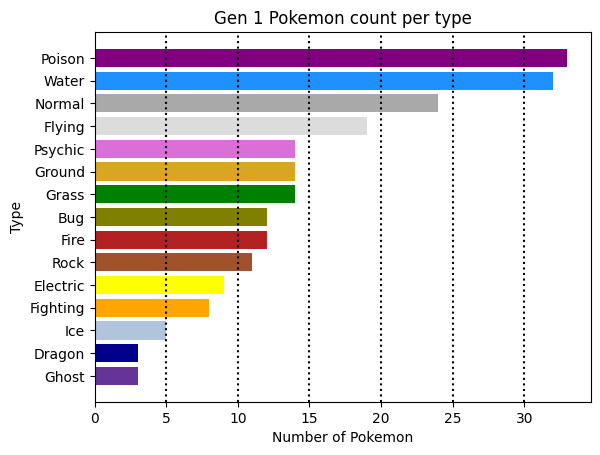

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualise the type distirbution
plt.barh(y=counts_sorted["type"], width=counts_sorted["count"], color=["rebeccapurple","darkblue","lightsteelblue","orange","yellow","sienna","firebrick","olive","green","goldenrod","orchid","gainsboro","darkgrey","dodgerblue","purple"])
plt.ylabel("Type")
plt.xlabel("Number of Pokemon")
plt.axvline(5,color="black",linestyle="dotted")
plt.axvline(10,color="black",linestyle="dotted")
plt.axvline(15,color="black",linestyle="dotted")
plt.axvline(20,color="black",linestyle="dotted")
plt.axvline(25,color="black",linestyle="dotted")
plt.axvline(30,color="black",linestyle="dotted")
plt.title("Gen 1 Pokemon count per type")
plt.show()
plt.clf()

In [ ]:
# Count of mono type pokemon type distirbuitons
mono_types = df[df.type_2 == ""]
mono_type_values_counts = mono_types.type_1.value_counts().reset_index()
mono_type_values_counts.columns = ["type","count"]
mono_type_values_counts = mono_type_values_counts.sort_values(by="count", ascending=True)

print(mono_type_values_counts)

        type  count
10     Grass      1
9     Dragon      2
8        Bug      3
7     Ground      6
6   Fighting      7
4   Electric      8
5    Psychic      8
2       Fire     10
3     Poison     10
1     Normal     16
0      Water     18


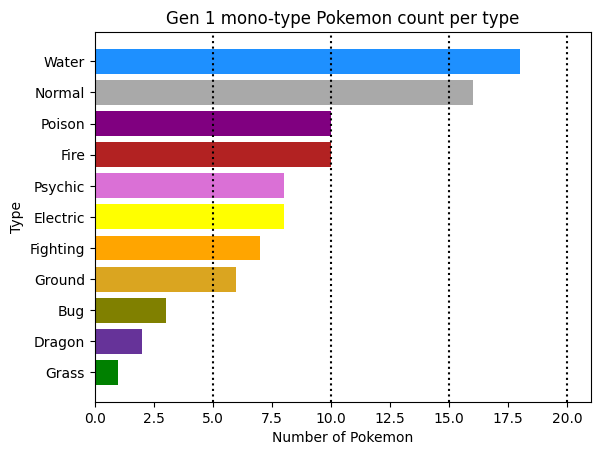

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualise the type distirbution
plt.barh(y=mono_type_values_counts["type"], width=mono_type_values_counts["count"], color=["green","rebeccapurple","olive", "goldenrod", "orange","yellow","orchid","firebrick", "purple","darkgrey","dodgerblue" ])
plt.ylabel("Type")
plt.xlabel("Number of Pokemon")
plt.axvline(5,color="black",linestyle="dotted")
plt.axvline(10,color="black",linestyle="dotted")
plt.axvline(15,color="black",linestyle="dotted")
plt.axvline(20,color="black",linestyle="dotted")
plt.title("Gen 1 mono-type Pokemon count per type")
plt.show()
plt.clf()

#4- Stat Distribution Analysis
What are the stat distributions for hp, attack, defence, special, speed and base stat total?

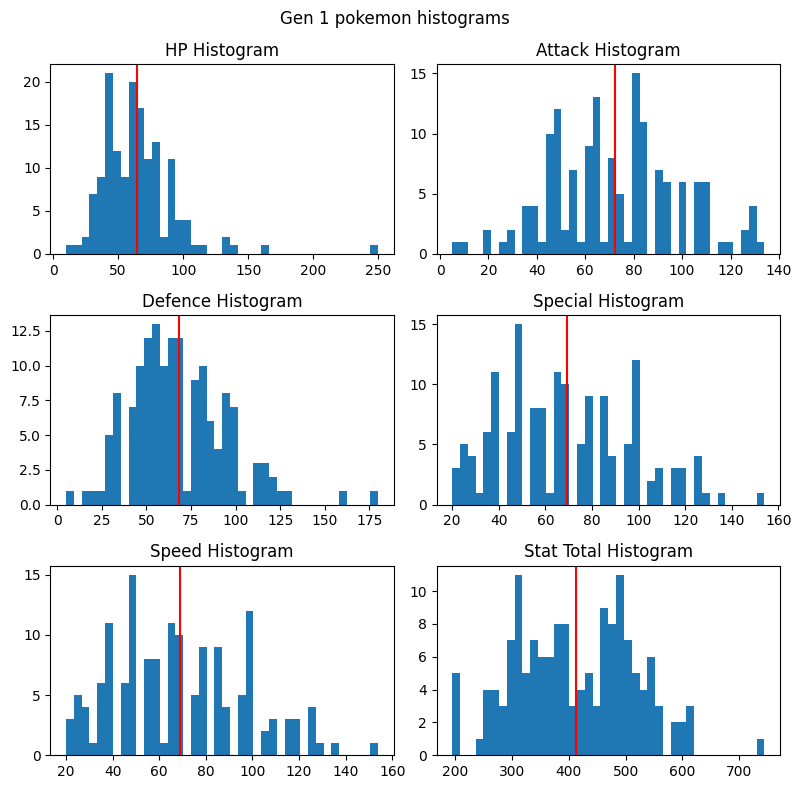

<Figure size 640x480 with 0 Axes>

In [ ]:
# Create the main figure
fig = plt.figure(figsize=(8,8))
fig.suptitle("Gen 1 pokemon histograms")

# HP histogram
plt.subplot(3,2,1)
plt.hist(df.hp, bins=40)
plt.axvline(np.mean(df.hp), color="red")
plt.title("HP Histogram")

# attack histogram
plt.subplot(3,2,2)
plt.hist(df.attack, bins=40)
plt.axvline(np.mean(df.attack), color="red")
plt.title("Attack Histogram")

# defence histogram
plt.subplot(3,2,3)
plt.hist(df.defence, bins=40)
plt.axvline(np.mean(df.defence), color="red")
plt.title("Defence Histogram")

# special histogram
plt.subplot(3,2,4)
plt.hist(df.sp_attack, bins=40)
plt.axvline(np.mean(df.sp_attack), color="red")
plt.title("Special Histogram")

# special histogram
plt.subplot(3,2,5)
plt.hist(df.sp_attack, bins=40)
plt.axvline(np.mean(df.speed), color="red")
plt.title("Speed Histogram")

# totals histogram
plt.subplot(3,2,6)
plt.hist(df.total, bins=40)
plt.axvline(np.mean(df.total), color="red")
plt.title("Stat Total Histogram")

plt.tight_layout()
plt.show()
plt.clf()

#5- Create move data frame
Generate the data frame for each move to be used in the damage analysis and save to GitHub.

In [ ]:
# Pokemon move list DataFrame
move_names = ["Hyper Beam", "Psychic", "Thunder", "Explosion", "Fire Blast","Hydro Pump","Solar Beam"]
move_types = ["Normal", "Psychic", "Electric", "Normal", "Fire","Water","Grass"]
move_power = [150, 90, 120, 170, 120, 120, 120]
move_data = list(zip(move_names, move_types, move_power))

move_list = pd.DataFrame(move_data, columns=["move_name","type","power"])
print(move_list)

# Create csv
move_list.to_csv("gen_1_powerful_moves.csv")

    move_name      type  power
0  Hyper Beam    Normal    150
1     Psychic   Psychic     90
2     Thunder  Electric    120
3   Explosion    Normal    170
4  Fire Blast      Fire    120
5  Hydro Pump     Water    120
6  Solar Beam     Grass    120


#6- Calculations and formula
Creation of the functions to find type effectiveness, calculate pokemon stats and extract those values from the DataFrame by passing the pokemon names as arguments.

## Type Effectiveness Formula
Creation of the functions to find type effectiveness, calculate pokemon stats and extract those values from the DataFrame by passing the pokemon names as arguments.

In [ ]:
# Import from GitHub after saving CSVs
poke_df = pd.read_csv("https://raw.githubusercontent.com/thecyberdragon/data-analysis/main/pokemon_gen_1/pokemon_gen_1_stats_types.csv")
move_df = pd.read_csv("https://raw.githubusercontent.com/thecyberdragon/data-analysis/main/pokemon_gen_1/gen_1_powerful_moves.csv")

print(poke_df.head())
print(move_df.head())

   Unnamed: 0  dex        name type_1  type_2  hp  attack  defence  sp_attack  \
0           0    1   Bulbasaur  Grass  Poison  45      49       49         65   
1           1    2     Ivysaur  Grass  Poison  60      62       63         80   
2           2    3    Venusaur  Grass  Poison  80      82       83        100   
3           3    4  Charmander   Fire     NaN  39      52       43         50   
4           4    5  Charmeleon   Fire     NaN  58      64       58         65   

   sp_defence  speed  total  
0          65     45    318  
1          80     60    405  
2         100     80    525  
3          50     65    299  
4          65     80    390  
   Unnamed: 0   move_name      type  power
0           0  Hyper Beam    Normal    150
1           1     Psychic   Psychic     90
2           2     Thunder  Electric    120
3           3   Explosion    Normal    170
4           4  Fire Blast      Fire    120


In [ ]:
# Type Effectiveness Calculation
def TypeEffectiveness(attacking_type, typing):

  # Establish type weaknesses and strengths
  normal = {"Rock":0.5, "Ghost":0}
  fire = {"Fire":0.5, "Water":0.5, "Grass":2, "Ice":2, "Bug":2, "Rock":0.5, "Dragon":0.5}
  water = {"Fire":2, "Water":0.5, "Grass":0.5, "Ground":2, "Rock":2, "Dragon":0.5}
  electric = {"Water":2, "Electric":0.5, "Grass":0.5, "Ground":0, "Flying":2, "Dragon":0.5}
  grass = {"Fire":0.5, "Water":2, "Grass":0.5, "Poison":0.5, "Ground":2, "Flying":0.5, "Bug":0.5, "Rock":2, "Dragon":0.5}
  ice = {"Water":0.5, "Grass":2, "Ice":0.5, "Flying":2, "Dragon":2}
  fighting = {"Normal":2, "Ice":2, "Poison":0.5, "Flying":0.5, "Psychic":0.5, "Bug":0.5, "Rock":2, "Ghost":0}
  poison = {"Grass":2, "Poison":0.5, "Ground":0.5, "Bug":2, "Rock":0.5, "Ghost":0.5}
  ground = {"Fire":2, "Electric":2, "Grass":0.5, "Poison":2, "Flying":0, "Bug":0.5, "Rock":2}
  flying = {"Electric":0.5, "Grass":2, "Fighting":2, "Bug":2, "Rock":0.5}
  psychic = {"Fighting":2, "Poison":2, "Psychic":0.5}
  bug = {"Fire":0.5, "Grass":2, "Fighting":0.5, "Poison":2, "Flying":0.5, "Psychic":2, "Ghost":0.5}
  rock = {"Fire":2, "Ice":2, "Fighting":0.5, "Ground":0.5, "Flying":2, "Bug":2}
  ghost = {"Ghost":2}
  dragon = {"Dragon":2}

  # Consolidate dictionaries into a master dictionary
  type_dictionary = {"Normal":normal, "Fire":fire, "Water":water, "Electric":electric, "Grass":grass, "Ice":ice, "Fighting":fighting,
                     "Poison":poison, "Ground":ground, "Flying":flying, "Psychic":psychic, "Bug":bug, "Rock":rock, "Ghost":ghost, "Dragon":dragon }

  # Set the damage variable
  damage = 1

  # For each type of the defending pokemon
  for poketype in typing:

    # Switch to call the master dictionary
    if poketype != "":
      match attacking_type:
        case "Normal":
          if poketype in type_dictionary.get("Normal").keys(): damage *= normal[poketype]
        case "Fire":
          if poketype in type_dictionary.get("Fire").keys(): damage *= fire[poketype]
        case "Water":
          if poketype in type_dictionary.get("Water").keys(): damage *= water[poketype]
        case "Electric":
          if poketype in type_dictionary.get("Electric").keys(): damage *= electric[poketype]
        case "Grass":
          if poketype in type_dictionary.get("Grass").keys(): damage *= grass[poketype]
        case "Ice":
          if poketype in type_dictionary.get("Ice").keys(): damage *= ice[poketype]
        case "Fighting":
          if poketype in type_dictionary.get("Fighting").keys(): damage *= fighting[poketype]
        case "Poison":
          if poketype in type_dictionary.get("Poison").keys(): damage *= poison[poketype]
        case "Ground":
          if poketype in type_dictionary.get("Ground").keys(): damage *= ground[poketype]
        case "Flying":
          if poketype in type_dictionary.get("Flying").keys(): damage *= flying[poketype]
        case "Psychic":
          if poketype in type_dictionary.get("Psychic").keys(): damage *= psychic[poketype]
        case "Bug":
          if poketype in type_dictionary.get("Bug").keys(): damage *= bug[poketype]
        case "Rock":
          if poketype in type_dictionary.get("Rock").keys(): damage *= rock[poketype]
        case "Ghost":
          if poketype in type_dictionary.get("Ghost").keys(): damage *= ghost[poketype]
        case "Dragon":
          if poketype in type_dictionary.get("Dragon").keys(): damage *= dragon[poketype]

  # Return combined damage
  return damage

In [ ]:
# Level 100 stats calculation (max IVs, max EVs)
# Max IV = 1111 = 15
# HP IV = 1111 = 15
# EVs per stat = 65535

def MaxLvl100Stats(hp, attack, defence, sp_atk, sp_def, speed):

  # Calculate each stat with perfect IV and EVs
  hp_stat = (((((hp + 15) * 2) + ((65535 ** 0.5)/4)) * 100) / 100) + 100 + 10
  attack_stat = (((((attack + 15) * 2) + ((attack ** 0.5))/4) * 100) / 100) + 5
  defence_stat = (((((defence + 15) * 2) + ((defence ** 0.5))/4) * 100) / 100) + 5
  special_atk_stat = (((((sp_atk + 15) * 2) + ((sp_atk ** 0.5))/4) * 100) / 100) + 5
  special_def_stat = (((((sp_def + 15) * 2) + ((sp_def ** 0.5))/4) * 100) / 100) + 5
  speed_stat = (((((speed + 15) * 2) + ((speed ** 0.5))/4) * 100) / 100) + 5

  # Return as a list
  return int(np.floor(hp_stat)),int(np.floor(attack_stat)),int(np.floor(defence_stat)),int(np.floor(special_atk_stat)),int(np.floor(special_def_stat)) , int(np.floor(speed_stat))

def ExtractPokemonStats(pokemon):

  # Find stats of this pokemon
  this_pokemon = poke_df[poke_df.name == pokemon].reset_index()

  # Extract values from DataFrame
  hp = this_pokemon.loc[0,"hp"]
  attack = this_pokemon.loc[0,"attack"]
  defence = this_pokemon.loc[0,"defence"]
  special_attack = this_pokemon.loc[0,"sp_attack"]
  special_defence = this_pokemon.loc[0,"sp_defence"]
  speed = this_pokemon.loc[0,"speed"]

  # Return as a list
  return[hp, attack, defence, special_attack, special_defence, speed]

def ExtractAndCalculateStats(pokemon, explain):
  # Extract the base stats
  base_stats = ExtractPokemonStats(pokemon)
  # Calculate the maximum stats
  max_stats = MaxLvl100Stats(base_stats[0],base_stats[1],base_stats[2],base_stats[3],base_stats[4],base_stats[5])
  # Display for the user
  if explain == True:
    print("Pokemon: " + pokemon)
    print("HP: " + str(max_stats[0]))
    print("Attack: " + str(max_stats[1]))
    print("Defence: " + str(max_stats[2]))
    print("Special Attack: " + str(max_stats[3]))
    print("Special Defence: " + str(max_stats[4]))
    print("Speed: " + str(max_stats[5]))

  return max_stats

In [ ]:
# Dual type test
charizard = poke_df[poke_df.name == "Charizard"]
print("Charizard!")
charizard_typing = charizard.type_1.values.tolist() + charizard.type_2.values.tolist()
print("Typing: " + str(charizard_typing))
print("You threw a rock at the spicy boi. You did " + str(TypeEffectiveness("Rock",charizard_typing)) + "x damage!")
print("You shook the ground a bit. You did " + str(TypeEffectiveness("Ground",charizard_typing)) + "x damage!")
print("Boo! You made a big spook. You did " + str(TypeEffectiveness("Ghost",charizard_typing)) + "x damage!")
print("Zappy zappy! You did " + str(TypeEffectiveness("Electric",charizard_typing)) + "x damage!")

# Mono type test
pikachu = poke_df[poke_df.name == "Pikachu"]
print("\nPika pika!")
pikachu_typing = pikachu.type_1.values.tolist() + pikachu.type_2.values.tolist()
print("Typing: " + str(pikachu_typing))
print("You threw a rock at the zappy lad. You did " + str(TypeEffectiveness("Rock",pikachu_typing)) + "x damage!")
print("You turned into a bug. You did " + str(TypeEffectiveness("Bug",pikachu_typing)) + "x damage!")
print("You made the ground move abit. You did " + str(TypeEffectiveness("Ground",pikachu_typing)) + "x damage!")

Charizard!
Typing: ['Fire', 'Flying']
You threw a rock at the spicy boi. You did 4x damage!
You shook the ground a bit. You did 0x damage!
Boo! You made a big spook. You did 1x damage!
Zappy zappy! You did 2x damage!

Pika pika!
Typing: ['Electric', nan]
You threw a rock at the zappy lad. You did 1x damage!
You turned into a bug. You did 1x damage!
You made the ground move abit. You did 2x damage!


In [ ]:
# Stat Calculation Test
print()
pikachu = ExtractAndCalculateStats("Pikachu", True)
print()
mewtwo = ExtractAndCalculateStats("Mewtwo", True)


Pokemon: Pikachu
HP: 273
Attack: 146
Defence: 96
Special Attack: 136
Special Defence: 136
Speed: 217

Pokemon: Mewtwo
HP: 415
Attack: 257
Defence: 217
Special Attack: 346
Special Defence: 346
Speed: 297


## Level 100 stat calculation
Generate the maximum level 100 stats of each pokemon and saving to a new DataFrame and exporting to GitHub.

In [ ]:
# Add stats to dataframe
pokemon_names = poke_df.name.values.tolist()
poke_df_100 = poke_df.copy()

for pokemon in pokemon_names:

  # Calculate all level 100 stats
  lvl100_stats = ExtractAndCalculateStats(pokemon,False)
  hp_100 = lvl100_stats[0]
  atk_100 = lvl100_stats[1]
  def_100 = lvl100_stats[2]
  spatk_100 = lvl100_stats[3]
  spdef_100 = lvl100_stats[4]
  speed_100 = lvl100_stats[5]

  #Find in DataFrame and add it
  poke_df_100.loc[poke_df_100.name == pokemon, "hp_100"] = hp_100
  poke_df_100.loc[poke_df_100.name == pokemon, "atk_100"] = atk_100
  poke_df_100.loc[poke_df_100.name == pokemon, "def_100"] = def_100
  poke_df_100.loc[poke_df_100.name == pokemon, "spatk_100"] = spatk_100
  poke_df_100.loc[poke_df_100.name == pokemon, "spdef_100"] = spdef_100
  poke_df_100.loc[poke_df_100.name == pokemon, "speed_100"] = speed_100

# Convert the data types
poke_df_100.atk_100 = poke_df_100.atk_100.astype("int")
poke_df_100.def_100 = poke_df_100.def_100.astype("int")
poke_df_100.spatk_100 = poke_df_100.spatk_100.astype("int")
poke_df_100.spdef_100 = poke_df_100.spdef_100.astype("int")
poke_df_100.speed_100 = poke_df_100.speed_100.astype("int")

# Drop original stat columns
poke_df_100.drop("hp",axis=1,inplace=True)
poke_df_100.drop("attack",axis=1,inplace=True)
poke_df_100.drop("defence",axis=1,inplace=True)
poke_df_100.drop("sp_attack",axis=1,inplace=True)
poke_df_100.drop("sp_defence",axis=1,inplace=True)
poke_df_100.drop("speed",axis=1,inplace=True)
poke_df_100.drop("total",axis=1,inplace=True)

# Print the head and export CSV
print(poke_df_100.head(10))
poke_df_100.to_csv("pokemon_gen_1_level_100_stats_types.csv")


   Unnamed: 0  dex        name type_1  type_2  hp_100  atk_100  def_100  \
0           0    1   Bulbasaur  Grass  Poison   293.0      134      134   
1           1    2     Ivysaur  Grass  Poison   323.0      160      162   
2           2    3    Venusaur  Grass  Poison   363.0      201      203   
3           3    4  Charmander   Fire     NaN   281.0      140      122   
4           4    5  Charmeleon   Fire     NaN   319.0      165      152   
5           5    6   Charizard   Fire  Flying   359.0      205      193   
6           6    7    Squirtle  Water     NaN   291.0      132      167   
7           7    8   Wartortle  Water     NaN   321.0      162      197   
8           8    9   Blastoise  Water     NaN   361.0      203      237   
9           9   10    Caterpie    Bug     NaN   293.0       96      106   

   spatk_100  spdef_100  speed_100  
0        167        167        126  
1        197        197        156  
2        237        237        197  
3        136        136   

In [ ]:
# Import from GitHub after saving CSVs (updated)
poke_df = pd.read_csv("https://raw.githubusercontent.com/thecyberdragon/data-analysis/main/pokemon_gen_1/pokemon_gen_1_stats_types.csv")
move_df = pd.read_csv("https://raw.githubusercontent.com/thecyberdragon/data-analysis/main/pokemon_gen_1/gen_1_powerful_moves.csv")
poke_df_lvl100 = pd.read_csv("https://raw.githubusercontent.com/thecyberdragon/data-analysis/main/pokemon_gen_1/pokemon_gen_1_level_100_stats_types.csv")

## Damage calculation   
Taking an attacking and defending pokemon by name and passing a move name to calculate battle damage

In [ ]:
# Damage Calculation
def CalculateDamage(attacking_pokemon, defending_pokemon, move):

  # Extract values from DataFrames
  attacker_stats = poke_df_lvl100[poke_df_lvl100.name == attacking_pokemon].reset_index()
  attacker_type = [attacker_stats.loc[0,"type_1"], attacker_stats.loc[0,"type_2"]]

  defender_stats = poke_df_lvl100[poke_df_lvl100.name == defending_pokemon].reset_index()
  defender_type = [str(defender_stats.loc[0,"type_1"]) , str(defender_stats.loc[0,"type_2"])]

  move_used = move_df[move_df.move_name == move].reset_index()
  move_name = move_used.loc[0,"move_name"]
  move_power = move_used.loc[0,"power"]
  move_type = move_used.loc[0,"type"]

  # Extract attack stats of attacker
  attacker_atk = attacker_stats.loc[0,"atk_100"]
  attacker_spatk = attacker_stats.loc[0,"spatk_100"]

  # Extract defences of defender
  defender_def = defender_stats.loc[0,"def_100"]
  if move_name == "Explosion": defender_def = defender_def/2
  defender_spdef = defender_stats.loc[0,"spdef_100"]

  # Physical special typings
  physical_types = ["Bug","Fighting","Flying","Ghost","Ground","Normal","Poison","Rock"]
  special_types = ["Dragon","Electric","Fire","Grass","Ice","Psychic","Water"]

  # Set final attack and defence stats based on move typing
  attack_stat = 0
  defence_stat = 0
  if move_type in physical_types: attack_stat = attacker_atk; defence_stat = defender_def
  else: attack_stat = attacker_spatk; defence_stat = defender_spdef

  # Calculate stab
  stab = 1
  if move_type in attacker_type: stab = 1.5

  # Calculate type effectiveness
  multiplier = TypeEffectiveness(move_type, defender_type)

  # Calculate damage
  base_damage = np.floor(np.floor(((np.floor((100 * 2) / 5) + 2) * move_power * attack_stat) / defence_stat) / 50) + 2
  modified_damage = base_damage * multiplier

  return modified_damage

#7- Calculating type coverage for the pokedex
Using the calculation funtions to see type effectiveness for every pokemon in the pokedex and creating a new DataFrame, then turning it into a pivot table for visualisation.

In [ ]:
# Type effectiveness per type over the whole pokedex
poke_type_coverage_df = poke_df.copy()
poke_type_coverage_df.drop("hp",axis=1,inplace=True)
poke_type_coverage_df.drop("attack",axis=1,inplace=True)
poke_type_coverage_df.drop("defence",axis=1,inplace=True)
poke_type_coverage_df.drop("sp_attack",axis=1,inplace=True)
poke_type_coverage_df.drop("sp_defence",axis=1,inplace=True)
poke_type_coverage_df.drop("speed",axis=1,inplace=True)
poke_type_coverage_df.drop("total",axis=1,inplace=True)

types = ["Normal", "Fire", "Water", "Electric", "Grass", "Ice", "Fighting", "Poison", "Ground", "Flying", "Psychic", "Bug", "Rock", "Ghost", "Dragon"]

for type_name in types:
  for idx, row in poke_type_coverage_df.iterrows():
    pokemon = row["name"]
    typing = [row.type_1, row.type_2]
    effectiveness = TypeEffectiveness(type_name, typing)
    poke_type_coverage_df.loc[poke_type_coverage_df.name == pokemon, type_name] = effectiveness

print(poke_type_coverage_df.head())
poke_type_coverage_df.to_csv("pokemon_gen_1_type_coverage.csv")

   Unnamed: 0  dex        name type_1  type_2  Normal  Fire  Water  Electric  \
0           0    1   Bulbasaur  Grass  Poison     1.0   2.0    0.5       0.5   
1           1    2     Ivysaur  Grass  Poison     1.0   2.0    0.5       0.5   
2           2    3    Venusaur  Grass  Poison     1.0   2.0    0.5       0.5   
3           3    4  Charmander   Fire     NaN     1.0   0.5    2.0       1.0   
4           4    5  Charmeleon   Fire     NaN     1.0   0.5    2.0       1.0   

   Grass  Ice  Fighting  Poison  Ground  Flying  Psychic  Bug  Rock  Ghost  \
0   0.25  2.0       0.5     1.0     1.0     2.0      2.0  4.0   1.0    1.0   
1   0.25  2.0       0.5     1.0     1.0     2.0      2.0  4.0   1.0    1.0   
2   0.25  2.0       0.5     1.0     1.0     2.0      2.0  4.0   1.0    1.0   
3   0.50  1.0       1.0     1.0     2.0     1.0      1.0  0.5   2.0    1.0   
4   0.50  1.0       1.0     1.0     2.0     1.0      1.0  0.5   2.0    1.0   

   Dragon  
0     1.0  
1     1.0  
2     1.0  
3 

In [ ]:
# Read CSV from github back as a variable
poke_coverage_df = pd.read_csv("https://raw.githubusercontent.com/thecyberdragon/data-analysis/main/pokemon_gen_1/pokemon_gen_1_type_coverage.csv")

In [ ]:
# Setting value count DF's for barcharts
normal_values = poke_coverage_df.Normal.value_counts().reset_index(); normal_values.columns=["multi","count"]; normal_values["type"] = "Normal"
fire_values = poke_coverage_df.Fire.value_counts().reset_index(); fire_values.columns=["multi","count"]; fire_values["type"] = "Fire"
water_values = poke_coverage_df.Water.value_counts().reset_index(); water_values.columns=["multi","count"]; water_values["type"] = "Water"
electric_values = poke_coverage_df.Electric.value_counts().reset_index(); electric_values.columns=["multi","count"]; electric_values["type"] = "Electric"
grass_values = poke_coverage_df.Grass.value_counts().reset_index(); grass_values.columns=["multi","count"]; grass_values["type"] = "Grass"
ice_values = poke_coverage_df.Ice.value_counts().reset_index(); ice_values.columns=["multi","count"]; ice_values["type"] = "Ice"
fighting_values = poke_coverage_df.Fighting.value_counts().reset_index(); fighting_values.columns=["multi","count"]; fighting_values["type"] = "Fighting"
poison_values = poke_coverage_df.Poison.value_counts().reset_index(); poison_values.columns=["multi","count"]; poison_values["type"] = "Poison"
ground_values = poke_coverage_df.Ground.value_counts().reset_index(); ground_values.columns=["multi","count"]; ground_values["type"] = "Ground"
flying_values = poke_coverage_df.Flying.value_counts().reset_index(); flying_values.columns=["multi","count"]; flying_values["type"] = "Flying"
psychic_values = poke_coverage_df.Psychic.value_counts().reset_index(); psychic_values.columns=["multi","count"]; psychic_values["type"] = "Psychic"
bug_values = poke_coverage_df.Bug.value_counts().reset_index(); bug_values.columns=["multi","count"]; bug_values["type"] = "Bug"
rock_values = poke_coverage_df.Rock.value_counts().reset_index(); rock_values.columns=["multi","count"];rock_values["type"] = "Rock"
ghost_values = poke_coverage_df.Ghost.value_counts().reset_index(); ghost_values.columns=["multi","count"]; ghost_values["type"] = "Ghost"
dragon_values = poke_coverage_df.Dragon.value_counts().reset_index(); dragon_values.columns=["multi","count"]; dragon_values["type"] = "Dragon"

coverage_grouped = pd.concat([normal_values, fire_values, water_values, electric_values, grass_values, ice_values,
                              fighting_values, poison_values, ground_values, flying_values, psychic_values,
                              bug_values, rock_values, ghost_values,dragon_values])

pivot_coverage = coverage_grouped.pivot(
    columns="multi",
    index="type",
    values="count"
).reset_index()

pivot_coverage = pivot_coverage.fillna(0.0)
custom_range = [12,15,4,7,2,10,14,5,9,6,1,8,11,13,3]
for index, row in pivot_coverage.iterrows():
  pivot_coverage.at[index,"order"] = custom_range[index]
pivot_coverage= pivot_coverage.sort_values(by="order", ascending=False)
pivot_coverage.to_csv("pokemon_gen_1_type_coverage_pivot.csv")
print(pivot_coverage)
print(pivot_coverage.columns)

multi      type   0.0  0.25   0.5    1.0   2.0   4.0  order
1        Dragon   0.0   0.0   0.0  148.0   3.0   0.0   15.0
6         Ghost   0.0   0.0   0.0  148.0   3.0   0.0   14.0
13         Rock   0.0   0.0  22.0   86.0  38.0   5.0   13.0
0           Bug   0.0   2.0  33.0   71.0  34.0  11.0   12.0
12      Psychic   0.0   0.0  14.0   96.0  41.0   0.0   11.0
5        Flying   0.0   0.0  20.0   99.0  30.0   2.0   10.0
8        Ground  19.0   2.0   6.0   79.0  45.0   0.0    9.0
11       Poison   0.0  11.0  25.0  105.0   8.0   2.0    8.0
3      Fighting   3.0   9.0  46.0   64.0  29.0   0.0    7.0
9           Ice   0.0   3.0  29.0   86.0  32.0   1.0    6.0
7         Grass   0.0  23.0  41.0   46.0  31.0  10.0    5.0
2      Electric  14.0   0.0  24.0   65.0  47.0   1.0    4.0
14        Water   0.0   0.0  45.0   79.0  21.0   6.0    3.0
4          Fire   0.0   4.0  47.0   74.0  24.0   2.0    2.0
10       Normal   3.0   0.0  11.0  137.0   0.0   0.0    1.0
Index(['type', 0.0, 0.25, 0.5, 1.0, 2.0,

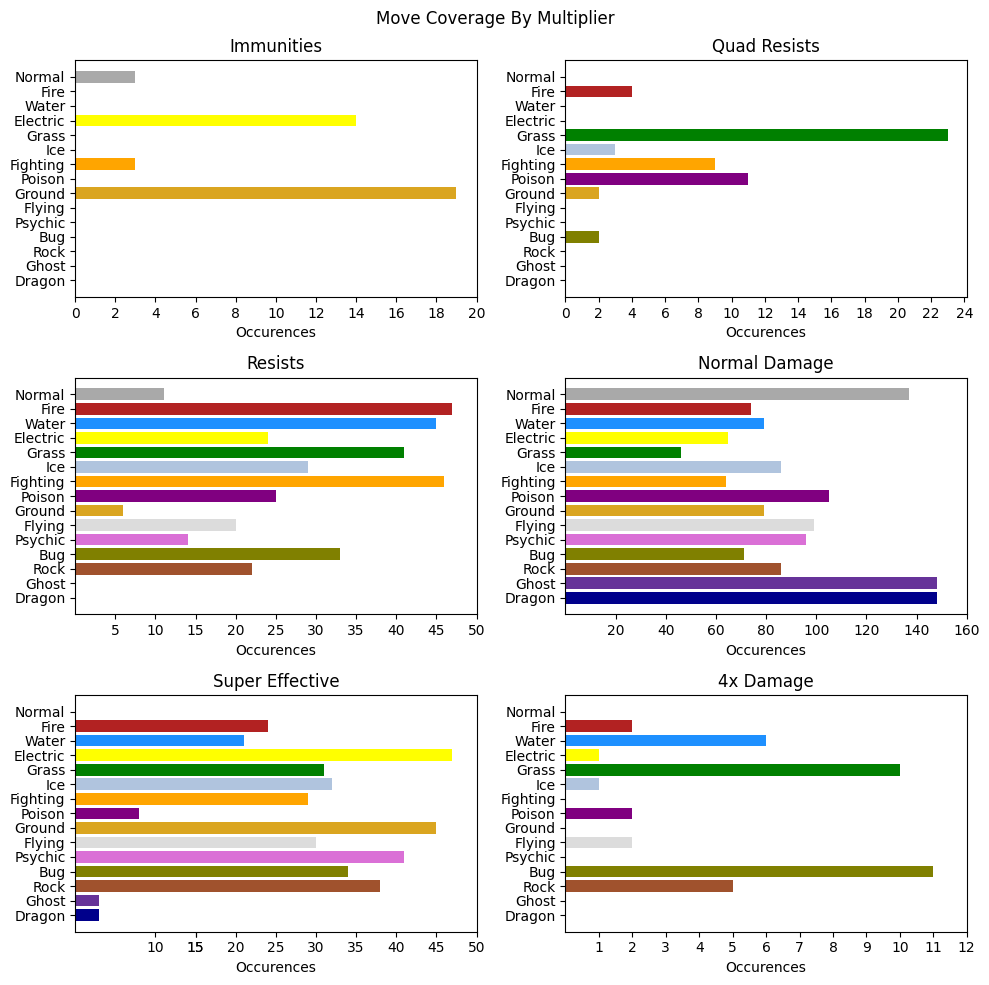

In [ ]:
# Chart plots of multipliers in the pokedex by type
colour_list = ["darkblue","rebeccapurple","sienna","olive","orchid","gainsboro","goldenrod","purple","orange","lightsteelblue","green","yellow","dodgerblue","firebrick","darkgrey"]

fig = plt.figure(figsize=(10,10))
fig.suptitle("Move Coverage By Multiplier")

ax = plt.subplot(3,2,1)
plt.title("Immunities")
plt.xlabel("Occurences")
plt.barh(y=pivot_coverage.type, width=pivot_coverage[0.0], color=colour_list)
ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20])

ax = plt.subplot(3,2,2)
plt.title("Quad Resists")
plt.xlabel("Occurences")
plt.barh(y=pivot_coverage.type, width=pivot_coverage[0.25], color=colour_list)
ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,24])

ax = plt.subplot(3,2,3)
plt.title("Resists")
plt.xlabel("Occurences")
plt.barh(y=pivot_coverage.type, width=pivot_coverage[0.5], color=colour_list)
ax.set_xticks([5,10,15,20,25,30,35,40,45,50])

ax = plt.subplot(3,2,4)
plt.title("Normal Damage")
plt.xlabel("Occurences")
plt.barh(y=pivot_coverage.type, width=pivot_coverage[1.0], color=colour_list)
ax.set_xticks([20,40,60,80,100,120,140,160])

ax = plt.subplot(3,2,5)
plt.title("Super Effective")
plt.xlabel("Occurences")
plt.barh(y=pivot_coverage.type, width=pivot_coverage[2.0], color=colour_list)
ax.set_xticks([15,10,15,20,25,30,35,40,45,50])

ax = plt.subplot(3,2,6)
plt.title("4x Damage")
plt.xlabel("Occurences")
plt.barh(y=pivot_coverage.type, width=pivot_coverage[4.0], color=colour_list)
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])

plt.tight_layout()
plt.show()

#8- Specific pokemon damage coverage
Finding the damage to all pokemon in the pokedex upon taking a hit from:
-Gyarados's hyper beam   
-Mewtwo's psychic   
-Pikachu's thunder   
-Golem's explosion   
-Charizard's fire blast   
-Blastoise's hydro pump   
-Venusaur's solar beam   

In [ ]:
# Read CSV from github back as a variable
poke_coverage_df = pd.read_csv("https://raw.githubusercontent.com/thecyberdragon/data-analysis/main/pokemon_gen_1/pokemon_gen_1_type_coverage.csv")
poke_df = pd.read_csv("https://raw.githubusercontent.com/thecyberdragon/data-analysis/main/pokemon_gen_1/pokemon_gen_1_stats_types.csv")
move_df = pd.read_csv("https://raw.githubusercontent.com/thecyberdragon/data-analysis/main/pokemon_gen_1/gen_1_powerful_moves.csv")
poke_df_lvl100 = pd.read_csv("https://raw.githubusercontent.com/thecyberdragon/data-analysis/main/pokemon_gen_1/pokemon_gen_1_level_100_stats_types.csv")

In [ ]:
# Calculate all damages in the pokedex per move
poke_df_damage = poke_df_lvl100.copy()

# Tests:
# Gyrados Hyper Beam
# Mewtwo Psychic
# Pikachu Thunder
# Golem Explosion
# Charizard Fire Blast
# Blastoise Hydro Pump
# Venasaur Solar Beam

for index, row in poke_df_damage.iterrows():
  pokemon = row["name"]
  poke_df_damage.at[index, "gyarados_hyperbeam"] = CalculateDamage("Gyarados",pokemon, "Hyper Beam")
  poke_df_damage.at[index, "mewtwo_psychic"] = CalculateDamage("Mewtwo",pokemon, "Psychic")
  poke_df_damage.at[index, "pikachu_thunder"] = CalculateDamage("Pikachu",pokemon, "Thunder")
  poke_df_damage.at[index, "golem_explosion"] = CalculateDamage("Golem",pokemon, "Explosion")
  poke_df_damage.at[index, "charizard_fireblast"] = CalculateDamage("Charizard",pokemon, "Fire Blast")
  poke_df_damage.at[index, "blastoise_hydropump"] = CalculateDamage("Blastoise",pokemon, "Hydro Pump")
  poke_df_damage.at[index, "venusaur_solarbeam"] = CalculateDamage("Venusaur",pokemon, "Solar Beam")

poke_df_damage.drop("speed_100", axis=1, inplace=True)
poke_df_damage.drop("spdef_100", axis=1, inplace=True)
poke_df_damage.drop("spatk_100", axis=1, inplace=True)
poke_df_damage.drop("def_100", axis=1, inplace=True)
poke_df_damage.drop("atk_100", axis=1, inplace=True)

print(poke_df_damage.head(5))
poke_df_damage.to_csv("pokemon_gen_1_damage.csv")

   Unnamed: 0.1  Unnamed: 0  dex        name type_1  type_2  hp_100  \
0             0           0    1   Bulbasaur  Grass  Poison     293   
1             1           1    2     Ivysaur  Grass  Poison     323   
2             2           2    3    Venusaur  Grass  Poison     363   
3             3           3    4  Charmander   Fire     NaN     281   
4             4           4    5  Charmeleon   Fire     NaN     319   

   gyarados_hyperbeam  mewtwo_psychic  pikachu_thunder  golem_explosion  \
0               271.0           316.0             42.0            549.0   
1               225.0           268.0             35.5            455.0   
2               180.0           224.0             29.5            363.0   
3               298.0           194.0            102.0            603.0   
4               239.0           158.0             84.0            484.0   

   charizard_fireblast  blastoise_hydropump  venusaur_solarbeam  
0                252.0                 63.0             

In [ ]:
# Describe the statistics of each move per pokemon
print(poke_df_damage[["gyarados_hyperbeam","mewtwo_psychic", "pikachu_thunder", "golem_explosion","charizard_fireblast","blastoise_hydropump","venusaur_solarbeam"]].describe())

       gyarados_hyperbeam  mewtwo_psychic  pikachu_thunder  golem_explosion  \
count          151.000000      151.000000       151.000000       151.000000   
mean           222.443709      210.311258       101.791391       450.046358   
std             97.977422      118.289655        71.622235       198.735749   
min              0.000000       38.500000         0.000000         0.000000   
25%            176.000000      128.000000        47.750000       356.000000   
50%            218.000000      192.000000        89.000000       441.000000   
75%            267.000000      271.000000       142.000000       541.000000   
max            805.000000      692.000000       364.000000      1633.000000   

       charizard_fireblast  blastoise_hydropump  venusaur_solarbeam  
count           151.000000           151.000000          151.000000  
mean            138.281457           157.062914          185.801325  
std             100.865593           146.410955          193.042254  
min     

### Gyarados Hyper Beam
Top 10 pokemon who:    
-Get overkilled   
-Resist   
-Barely live one hit   

In [ ]:
# Gyarados hyper beam analysis
print("Gyarados' hyper beam stats\n===============================")
gyarados = poke_df_damage[["name","hp_100","gyarados_hyperbeam"]]
gyarados.gyarados_hyperbeam = gyarados.gyarados_hyperbeam.astype("float")
gyarados = gyarados.sort_values(by="gyarados_hyperbeam", ascending=True)

print("\nTop 10 hardest hit pokemon")
gyarados_ohko = gyarados[gyarados.hp_100 < gyarados.gyarados_hyperbeam].reset_index()
gyarados_ohko["percent"] = gyarados_ohko.gyarados_hyperbeam / gyarados_ohko.hp_100 * 100
gyarados_ohko = gyarados_ohko.sort_values(by="percent", ascending=False)
print(gyarados_ohko.head(10))

print("\nTop 10 most resisted pokemon")
gyarados_lived = gyarados[gyarados.hp_100 > gyarados.gyarados_hyperbeam].reset_index()
gyarados_lived["percent"] = gyarados_lived.gyarados_hyperbeam / gyarados_lived.hp_100 * 100
gyarados_lived = gyarados_lived.sort_values(by="percent",ascending=True)
print(gyarados_lived.head(10))

print("\nPokemon who just make it (barely)")
gyarados_lived = gyarados_lived.sort_values(by="percent",ascending=False)
print(gyarados_lived.head(10))

gyarados_lived.to_csv("gyarados_hyperbeam_damage.csv")

Gyarados' hyper beam stats

Top 10 hardest hit pokemon
    index       name  hp_100  gyarados_hyperbeam     percent
23     62       Abra     253               558.0  220.553360
21     49    Diglett     223               422.0  189.237668
18     24    Pikachu     273               378.0  138.461538
20     63    Kadabra     283               378.0  133.568905
19     12     Weedle     283               378.0  133.568905
17     20    Spearow     283               378.0  133.568905
15     18    Rattata     263               343.0  130.418251
13     71  Tentacool     283               343.0  121.201413
16     55     Mankey     283               343.0  121.201413
9      51     Meowth     283               343.0  121.201413

Top 10 most resisted pokemon
    index      name  hp_100  gyarados_hyperbeam    percent
0      91    Gastly     263                 0.0   0.000000
1      92   Haunter     293                 0.0   0.000000
2      93    Gengar     323                 0.0   0.000000
6     11

<ipython-input-17-3032f0151f31>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gyarados.gyarados_hyperbeam = gyarados.gyarados_hyperbeam.astype("float")


### Mewtwo Psychic
Top 10 pokemon who:    
-Get overkilled   
-Resist   
-Barely live one hit  

In [ ]:
# Mewtwo psychic analysis
print("Mewtwo psychic stats\n===============================")
mewtwo = poke_df_damage[["name","hp_100","mewtwo_psychic"]]
mewtwo.mewtwo_psychic = mewtwo.mewtwo_psychic.astype("float")
mewtwo = mewtwo.sort_values(by="mewtwo_psychic", ascending=True)

print("\nTop 10 hardest hit pokemon")
mewtwo_ohko = mewtwo[mewtwo.hp_100 < mewtwo.mewtwo_psychic].reset_index()
mewtwo_ohko["percent"] = mewtwo_ohko.mewtwo_psychic / mewtwo_ohko.hp_100 * 100
mewtwo_ohko = mewtwo_ohko.sort_values(by="percent", ascending=False)
print(mewtwo_ohko.head(10))

print("\nTop 10 most resisted pokemon")
mewtwo_lived = mewtwo[mewtwo.hp_100 > mewtwo.mewtwo_psychic].reset_index()
mewtwo_lived["percent"] = mewtwo_lived.mewtwo_psychic / mewtwo_lived.hp_100 * 100
mewtwo_lived = mewtwo_lived.sort_values(by="percent",ascending=True)
print(mewtwo_lived.head(10))

print("\nPokemon who just make it (barely)")
mewtwo_lived = mewtwo_lived.sort_values(by="percent",ascending=False)
print(mewtwo_lived.head(10))

mewtwo.to_csv("mewtwo_psychic_damage.csv")


Mewtwo psychic stats

Top 10 hardest hit pokemon
    index        name  hp_100  mewtwo_psychic     percent
24     12      Weedle     283           692.0  244.522968
23     13      Kakuna     293           612.0  208.873720
20     55      Mankey     283           496.0  175.265018
15     22       Ekans     273           454.0  166.300366
22    105   Hitmonlee     303           496.0  163.696370
21    106  Hitmonchan     303           496.0  163.696370
13     40       Zubat     283           454.0  160.424028
14     31    Nidoran♂     295           454.0  153.898305
18     28    Nidoran♀     313           454.0  145.047923
19     65      Machop     343           496.0  144.606414

Top 10 most resisted pokemon
    index       name  hp_100  mewtwo_psychic    percent
0     149     Mewtwo     415            38.5   9.277108
2     102  Exeggutor     393            46.5  11.832061
4      96      Hypno     373            49.5  13.270777
8     150        Mew     403            56.0  13.895782
1  

<ipython-input-18-54d563548fc5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mewtwo.mewtwo_psychic = mewtwo.mewtwo_psychic.astype("float")


### Pikachu Thunder
Top 10 pokemon who:    
-Get overkilled   
-Resist   
-Barely live one hit  

In [ ]:
# Pikachu thunder analysis
print("Pikachu thunder stats\n===============================")
pikachu = poke_df_damage[["name","hp_100","pikachu_thunder"]]
pikachu.pikachu_thunder = pikachu.pikachu_thunder.astype("float")
pikachu = pikachu.sort_values(by="pikachu_thunder", ascending=True)

print("\nTop 10 hardest hit pokemon")
pikachu_ohko = pikachu[pikachu.hp_100 < pikachu.pikachu_thunder].reset_index()
pikachu_ohko["percent"] = pikachu_ohko.pikachu_thunder / pikachu_ohko.hp_100 * 100
pikachu_ohko = pikachu_ohko.sort_values(by="percent", ascending=False)
print(pikachu_ohko.head(10))

print("\nTop 10 most resisted pokemon")
pikachu_lived = pikachu[pikachu.hp_100 > pikachu.pikachu_thunder].reset_index()
pikachu_lived["percent"] = pikachu_lived.pikachu_thunder / pikachu_lived.hp_100 * 100
pikachu_lived = pikachu_lived.sort_values(by="percent",ascending=True)
print(pikachu_lived.head(10))

print("\nTop 10 most resisted pokemon where damage is greater than 0")
pikachu_lived = pikachu[(pikachu.hp_100 > pikachu.pikachu_thunder) & (pikachu.pikachu_thunder > 0)].reset_index()
pikachu_lived["percent"] = pikachu_lived.pikachu_thunder / pikachu_lived.hp_100 * 100
pikachu_lived = pikachu_lived.sort_values(by="percent",ascending=True)
print(pikachu_lived.head(10))

print("\nPokemon who just make it (barely)")
pikachu_lived = pikachu_lived.sort_values(by="percent",ascending=False)
print(pikachu_lived.head(10))

pikachu.to_csv("pikachu_thunder_damage.csv")


Pikachu thunder stats

Top 10 hardest hit pokemon
   index      name  hp_100  pikachu_thunder     percent
1    128  Magikarp     243            364.0  149.794239
0     97    Krabby     263            322.0  122.433460

Top 10 most resisted pokemon
    index      name  hp_100  pikachu_thunder  percent
0      75     Golem     363              0.0      0.0
13    104   Marowak     323              0.0      0.0
12    111    Rhydon     413              0.0      0.0
11    110   Rhyhorn     363              0.0      0.0
10     33  Nidoking     365              0.0      0.0
9     103    Cubone     303              0.0      0.0
7      74  Graveler     313              0.0      0.0
8      94      Onix     273              0.0      0.0
5      50   Dugtrio     273              0.0      0.0
4      49   Diglett     223              0.0      0.0

Top 10 most resisted pokemon where damage is greater than 0
    index        name  hp_100  pikachu_thunder    percent
0     102   Exeggutor     393          

<ipython-input-27-7010ba8fbcb8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pikachu.pikachu_thunder = pikachu.pikachu_thunder.astype("float")


### Golem Explosion
Top 10 pokemon who:    
-Get overkilled   
-Resist   
-Barely live one hit  

In [ ]:
# Golem explosion analysis
print("Golem explosion stats\n===============================")
golem = poke_df_damage[["name","hp_100","golem_explosion"]]
golem.golem_explosion = golem.golem_explosion.astype("float")
golem = golem.sort_values(by="golem_explosion", ascending=True)

print("\nTop 10 hardest hit pokemon")
golem_ohko = golem[golem.hp_100 < golem.golem_explosion].reset_index()
golem_ohko["percent"] = golem_ohko.golem_explosion / golem_ohko.hp_100 * 100
golem_ohko = golem_ohko.sort_values(by="percent", ascending=False)
print(golem_ohko.head(10))

print("\nTop 10 most resisted pokemon")
golem_lived = golem[golem.hp_100 > golem.golem_explosion].reset_index()
golem_lived["percent"] = golem_lived.golem_explosion / golem_lived.hp_100 * 100
golem_lived = golem_lived.sort_values(by="percent",ascending=True)
print(golem_lived.head(10))

print("\nPokemon who just make it (barely)")
golem_lived = golem_lived.sort_values(by="percent",ascending=False)
print(golem_lived.head(10))

golem.to_csv("golem_explosion_damage.csv")


Golem explosion stats

Top 10 hardest hit pokemon
     index       name  hp_100  golem_explosion     percent
107     62       Abra     253           1131.0  447.035573
105     49    Diglett     223            855.0  383.408072
102     24    Pikachu     273            766.0  280.586081
104     63    Kadabra     283            766.0  270.671378
103     12     Weedle     283            766.0  270.671378
101     20    Spearow     283            766.0  270.671378
99      18    Rattata     263            694.0  263.878327
97      71  Tentacool     283            694.0  245.229682
93      51     Meowth     283            694.0  245.229682
100     55     Mankey     283            694.0  245.229682

Top 10 most resisted pokemon
    index      name  hp_100  golem_explosion    percent
0      91    Gastly     263              0.0   0.000000
1      92   Haunter     293              0.0   0.000000
2      93    Gengar     323              0.0   0.000000
6     111    Rhydon     413            133.0  3

<ipython-input-28-0bdfcf3c59f1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  golem.golem_explosion = golem.golem_explosion.astype("float")


### Venusaur Solar Beam
Top 10 pokemon who:   
-Get overkilled   
-Resist    
-Barely live one hit    

In [ ]:
# Venusaur solar beam analysis
print("Venusaur solar beam stats\n===============================")
venusaur = poke_df_damage[["name","hp_100","venusaur_solarbeam"]]
venusaur.venusaur = venusaur.venusaur_solarbeam.astype("float")
venusaur = venusaur.sort_values(by="venusaur_solarbeam", ascending=True)

print("\nTop 10 hardest hit pokemon")
venusaur_ohko = venusaur[venusaur.hp_100 < venusaur.venusaur_solarbeam].reset_index()
venusaur_ohko["percent"] = venusaur_ohko.venusaur_solarbeam / venusaur_ohko.hp_100 * 100
venusaur_ohko = venusaur_ohko.sort_values(by="percent", ascending=False)
print(venusaur_ohko.head(10))

print("\nTop 10 most resisted pokemon")
venusaur_lived = venusaur[venusaur.hp_100 > venusaur.venusaur_solarbeam].reset_index()
venusaur_lived["percent"] = venusaur_lived.venusaur_solarbeam / venusaur_lived.hp_100 * 100
venusaur_lived = venusaur_lived.sort_values(by="percent",ascending=True)
print(venusaur_lived.head(10))

print("\nPokemon who just make it (barely)")
venusaur_lived = venusaur_lived.sort_values(by="percent",ascending=False)
print(venusaur_lived.head(10))

venusaur.to_csv("charizard_solarbeam_damage.csv")

Venusaur solar beam stats

Top 10 hardest hit pokemon
    index      name  hp_100  venusaur_solarbeam     percent
25     94      Onix     273              1000.0  366.300366
26     73   Geodude     283              1000.0  353.356890
21    139    Kabuto     263               764.0  290.494297
24    110   Rhyhorn     363              1000.0  275.482094
19    128  Magikarp     243               632.0  260.082305
22     74  Graveler     313               764.0  244.089457
18     97    Krabby     263               558.0  212.167300
23    111    Rhydon     413               764.0  184.987893
20     75     Golem     363               660.0  181.818182
11     49   Diglett     223               382.0  171.300448

Top 10 most resisted pokemon
    index        name  hp_100  venusaur_solarbeam   percent
0     145     Moltres     383               21.25  5.548303
3     148   Dragonite     385               25.50  6.623377
1       2    Venusaur     363               25.50  7.024793
2      70  Victr

<ipython-input-29-cd3a3471c7fe>:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  venusaur.venusaur = venusaur.venusaur_solarbeam.astype("float")


### Charizard Fire Blast
Top 10 pokemon who:   
-Get overkilled   
-Resist    
-Barely live one hit  

In [ ]:
# Charizard fire blast analysis
print("Charizard fire blast stats\n===============================")
charizard = poke_df_damage[["name","hp_100","charizard_fireblast"]]
charizard.charizard = charizard.charizard_fireblast.astype("float")
charizard = charizard.sort_values(by="charizard_fireblast", ascending=True)

print("\nTop 10 hardest hit pokemon")
charizard_ohko = charizard[charizard.hp_100 < charizard.charizard_fireblast].reset_index()
charizard_ohko["percent"] = charizard_ohko.charizard_fireblast / charizard_ohko.hp_100 * 100
charizard_ohko = charizard_ohko.sort_values(by="percent", ascending=False)
print(charizard_ohko.head(10))

print("\nTop 10 most resisted pokemon")
charizard_lived = charizard[charizard.hp_100 > charizard.charizard_fireblast].reset_index()
charizard_lived["percent"] = charizard_lived.charizard_fireblast / charizard_lived.hp_100 * 100
charizard_lived = charizard_lived.sort_values(by="percent",ascending=True)
print(charizard_lived.head(10))

print("\nPokemon who just make it (barely)")
charizard_lived = charizard_lived.sort_values(by="percent",ascending=False)
print(charizard_lived.head(10))

charizard.to_csv("charizard_fireblast_damage.csv")

Charizard fire blast stats

Top 10 hardest hit pokemon
   index      name  hp_100  charizard_fireblast     percent
7     45     Paras     273                576.0  210.989011
5     12    Weedle     283                552.0  195.053004
6      9  Caterpie     293                552.0  188.395904
3     13    Kakuna     293                488.0  166.552901
4     10   Metapod     303                488.0  161.056106
2     46  Parasect     323                428.0  132.507740
1     47   Venonat     323                362.0  112.074303
0     14  Beedrill     333                334.0  100.300300

Top 10 most resisted pokemon
    index        name  hp_100  charizard_fireblast    percent
0     138     Omastar     343                20.00   5.830904
5     133    Vaporeon     463                41.50   8.963283
1     137     Omanyte     273                24.50   8.974359
2     140    Kabutops     323                29.75   9.210526
3     145     Moltres     383                37.00   9.660574
4  

<ipython-input-30-54069d703786>:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  charizard.charizard = charizard.charizard_fireblast.astype("float")


### Blastoise Hydro pump

Top 10 pokemon who:   
-Get overkilled   
-Resist    
-Barely live one hit  

In [ ]:
# Blastoise hydro pump analysis
print("Blastoise hydro pump stats\n===============================")
blastoise = poke_df_damage[["name","hp_100","blastoise_hydropump"]]
blastoise.blastoise = blastoise.blastoise_hydropump.astype("float")
blastoise = blastoise.sort_values(by="blastoise_hydropump", ascending=True)

print("\nTop 10 hardest hit pokemon")
blastoise_ohko = blastoise[blastoise.hp_100 < blastoise.blastoise_hydropump].reset_index()
blastoise_ohko["percent"] = blastoise_ohko.blastoise_hydropump / blastoise_ohko.hp_100 * 100
blastoise_ohko = blastoise_ohko.sort_values(by="percent", ascending=False)
print(blastoise_ohko.head(10))

print("\nTop 10 most resisted pokemon")
blastoise_lived = blastoise[blastoise.hp_100 > blastoise.blastoise_hydropump].reset_index()
blastoise_lived["percent"] = blastoise_lived.blastoise_hydropump / blastoise_lived.hp_100 * 100
blastoise_lived = blastoise_lived.sort_values(by="percent",ascending=True)
print(blastoise_lived.head(10))

print("\nPokemon who just make it (barely)")
blastoise_lived = blastoise_lived.sort_values(by="percent",ascending=False)
print(blastoise_lived.head(10))

blastoise.to_csv("blastoise_hydropump_damage.csv")

Blastoise hydro pump stats

Top 10 hardest hit pokemon
   index        name  hp_100  blastoise_hydropump     percent
8     94        Onix     273                876.0  320.879121
9     73     Geodude     283                876.0  309.540636
7    110     Rhyhorn     363                876.0  241.322314
5     74    Graveler     313                668.0  213.418530
6    111      Rhydon     413                668.0  161.743341
4     75       Golem     363                576.0  158.677686
1     49     Diglett     223                334.0  149.775785
3     26   Sandshrew     303                438.0  144.554455
2    103      Cubone     303                362.0  119.471947
0      3  Charmander     281                310.0  110.320285

Top 10 most resisted pokemon
    index        name  hp_100  blastoise_hydropump    percent
2     133    Vaporeon     463                 41.5   8.963283
0     102   Exeggutor     393                 37.0   9.414758
13    130      Lapras     463                 4

<ipython-input-31-b4302c436c86>:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  blastoise.blastoise = blastoise.blastoise_hydropump.astype("float")


# Summary and Overview

## Type Distributions   
Interestingly, the top three mono-type pokemon types (water, normal, poison) are also the top three dual-type pokemon types while not in that order (poison, water, normal).   

There are also no mono-type ghost, rock, ice or flying pokemon.  
The only mono-type grass Pokemon in the game is Tangela. All grass type Pokemon besides Tangela have a second typing which is almost always poison, except for Exeggcute line which is psychic.   

There being no mono-type flying pokemon is the most interesting one, because it's the fourth most common type in the game, but only appears with other typings. It is also never the primary type, it is always the second typing.   

A worthwhile note as well, is that fire is the fourth most common mono-type but is only the ninth most common type overall.   

## Stat Distributions
There wasn't too much of note with the dist distributions. The most notable thing seen is that HP and Defence all look normally distributed, while Attack and Special (which means special attack and special defence) have a visible distribution but it's more erratic as opposed to having a clear bell curve.   

Secondly, the Stat Total is the only bimodal distribution with two distinct clear peaks while the other stat distributions are unimodal.   

## Type Coverage
For immunities, the prevalence of dual-type flying Pokemon, it's no wonder that ground is the most commonly resisted type for 0x damage. Electric isn't far behind. As with the type distribution analysis, there are no mono-type rock pokemon because they all have secondary ground typing. Normal and Fighting are both resisted at 0x damage the same as this is only the Ghastly line.   

For quad-resists, grass is the most commonly quad-resisted type by far - over double the next type being poison.    

For resistances, it seems that fire, water and fighting are the two most commonly resisted types for 0.5x damage. This is probably due to the number of water, grass, and poison/flying types in the pokedex respectively. Interestingly, while Ground was the most commonly resisted for 0x damage, it's the least commonly resisted type for 0.5x damage. Psychic is also in the top three least resisted pokemon types in generation 1 which helps explain why they were so strong in competitive play.   

For normal damage, the top three types are ghost and dragon tied for first, with normal in second. Ghost and dragon both hit all types neutrally except themselves. Given there are only three of each type in the game being the Ghastly and Dratini line, they hit 148 pokemon neutrally each. Normal type's strength is it hits most types for neutral damage, hitting close to 140 pokemon for normal damage.   

For super-effective damage, Electric and Ground, the two most resisted for 0x damage are at the top of the type chart, followed closely by Psychic and Rock. With the prevalance of water, flying and poison types, these are overall strong typings. While poison is one of the most common typings in the game, it hits the least number of pokemon for super effective x2 damage, except for dragon and ghost which only hit themselves for 2x damage.   

Finally, for super-effective x4 damage, oddly, bug is the strongest type in the game, followed closely by grass. This is probably due to bug in generation 1 hitting poison types super-effectively, and grass poison are a common typing, along with grass psychic of the Exeggcute line. Grass is a strong typing purely for all of the rock ground types and the Kabuto line being rock water. In generation 1, there are no ground water types.   

## Damage Distributions for popular Pokemon
Largest hit   
Golem exploding on an Abra - 1131 damage - 447% of its total HP.
Golem does more damage to Chansey (1633) but as Chansey's HP is so high (703), it's a lower percentage than the top 10 pokemon by percentage of health taken. Chansey takes 232% damage while the 10th hardest hit is Makey taking 245% damage.

Smallest hit   
Charizard fire blasting an Omastar - 20 damage - 5.8% of its total HP.   
Close behind is Venusaur solar beaming a Moltres - 21 damage  5.5% of its total HP.   

Luckiest pokemon   
Dugtrio hit by Venusaur's solar beam, and Spearow hit by Pikachu's thunder both barely make it out alive on 1 HP.   

Highest average damage   
Golem's explosion averages 450 points of damage, second by Gyarados' hyper beam averaging 222 points of damage.   

Lowset average damage   
Pikachu does the least damage, averaging 101 points of damage. Second is Charizard's fire blast doing an average of 138 points of damage.   
   
Most and least consistent   
Of all seven pokemon, Pikachu's thunder while being the weakest, has the lowest deviation from the average of 101 with a standard deviation of 71.
Golem's explosion while the strongest average at 450, has the largest deviation from the average, with a standard deviation of 198.   
   
Finally, Blastoise and Venusaur seem to be the most middle-of-the-road pokemon, neither showing up as heavy or light hitters, with standard deviations in the middle of the distribution compared to the other five pokemon.

## In Summary   
Generation 1 was a pokedex filled with quirks, such as the absence of mono-type flying pokemon despite there being a lot of flying pokemon, and contains some unique mechanics like the combining of special attack and special defence into one 'special' stat. The types dictating the physical or special stats used is a strange and interesting mechanic, whereby pokemon cannot use their most effective stat for their same type attack bonus. This generation also had the most limited move pool. While bug type is the heaviest hitter for x4 damage, there aren't any good bug moves. All-in-all, this analysis was a fun trip down memory lane and provided some interesting insights into the original pokedex.


# Sandbox Area
This is to allow anyone curious about the data to have a play around and see the results of their own queries.   

Instructions:    
1- Run 1- All Library Imports   
2- Run all cells in order in 6- Calculations and formula   
3- To analyse damage for a move that hasn't been added, run the cell below with the move data you want to add

In [ ]:
def AddMove(name, typing, power):
  move_df.loc[len(move_df)] = {"move_name":name, "type":typing, "power":power}

AddMove("Sky Attack", "Flying", 140)
print(move_df)

# Moves can be found here: https://www.smogon.com/dex/rb/moves/

   Unnamed: 0   move_name      type  power
0         0.0  Hyper Beam    Normal    150
1         1.0     Psychic   Psychic     90
2         2.0     Thunder  Electric    120
3         3.0   Explosion    Normal    170
4         4.0  Fire Blast      Fire    120
5         5.0  Hydro Pump     Water    120
6         6.0  Solar Beam     Grass    120
7         NaN  Sky Attack    Flying    140


In [ ]:
# Gen 1 type coverage
attacking_type = "Poison"
type_1 = "Rock"
type_2 = "Flying"
defending_type = [type_1, type_2]
type_damage = TypeEffectiveness(attacking_type, defending_type)
print(attacking_type + " attacking " + str(defending_type) + " does " + str(type_damage) + "x damage!\n")

# Show max level 100 Stats
pokemon_name = "Charizard"
ExtractAndCalculateStats(pokemon_name, True)

# Show damage calculation
attacking_pokemon = "Pidgey"
defending_pokemon = "Bellsprout"
attacking_move = "Sky Attack"
damage_dealt = CalculateDamage(attacking_pokemon, defending_pokemon, attacking_move)
print("\n" + attacking_pokemon + " using " + attacking_move + " against a " + defending_pokemon + " does " + str(damage_dealt) + " damage!")

Poison attacking ['Rock', 'Flying'] does 0.5x damage!

Pokemon: Charizard
HP: 359
Attack: 205
Defence: 193
Special Attack: 207
Special Defence: 207
Speed: 237

Pidgey using Sky Attack against a Bellsprout does 282.0 damage!


# Data Visulisation in Tableau
I've done some data vis and made a nice swanky dashboard on Tableau.   
Here's a link to it:   
https://public.tableau.com/app/profile/cyberdragon/viz/Pokemon-Generation1DataAnalysis/Generation1Analysis?publish=yes